In [1]:
!rocm-smi



========================================= ROCm System Management Interface =========================================
=================================================== Concise Info ===================================================
Device  Node  IDs              Temp    Power  Partitions          SCLK    MCLK     Fan  Perf  PwrCap  VRAM%  GPU%  
              (DID,     GUID)  (Edge)  (Avg)  (Mem, Compute, ID)                                                   
0       4     0x740c,   57586  44.0°C  87.0W  N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  560.0W  0%     0%    
1       5     0x740c,   45873  43.0°C  N/A    N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  0.0W    0%     0%    
2       2     0x740c,   14571  38.0°C  92.0W  N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  560.0W  0%     0%    
3       3     0x740c,   27432  34.0°C  N/A    N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  0.0W    0%     0%    
4       8     0x740c,   30939  38.0°C  94.0W  N/A, N/A, 0         80

In [2]:
import torch

print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i))

True
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=38363933-6532-6639-6638-643438353066, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=61303265-6137-3733-3161-313839323838, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=38356530-3739-3264-3035-646631353033, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=32356634-3338-3763-3932-633762333235, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
from datasets import load_dataset

dataset = load_dataset("peluz/lener_br", 
                        trust_remote_code=True,
                        )

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})

In [5]:
label_list = dataset["train"].features[f"ner_tags"].feature.names

label_list

['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

In [6]:
model_name = "answerdotai/ModernBERT-base"

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        padding="max_length",
        max_length=512,
        is_split_into_words=True,
    )

    labels = []

    for i, label in enumerate(example[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None: # [CLS], [SEP]
                label_ids.append(-100)

            elif word_idx != previous_word_idx: # new word
                label_ids.append(label[word_idx])

            else: # suffix of a previous token
                label_ids.append(-100)

            previous_word_idx = word_idx
            
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels

    return tokenized_inputs

encoded_dataset = dataset.map(
    tokenize_and_align_labels, 
    batched=True,
)

encoded_dataset = encoded_dataset.remove_columns(["id"])

encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1390
    })
})

In [8]:
id2label = {}
label2id = {}

for i, lab in enumerate(label_list):

    id2label[i] = lab
    label2id[lab] = i

print(id2label)
print(label2id)

{0: 'O', 1: 'B-ORGANIZACAO', 2: 'I-ORGANIZACAO', 3: 'B-PESSOA', 4: 'I-PESSOA', 5: 'B-TEMPO', 6: 'I-TEMPO', 7: 'B-LOCAL', 8: 'I-LOCAL', 9: 'B-LEGISLACAO', 10: 'I-LEGISLACAO', 11: 'B-JURISPRUDENCIA', 12: 'I-JURISPRUDENCIA'}
{'O': 0, 'B-ORGANIZACAO': 1, 'I-ORGANIZACAO': 2, 'B-PESSOA': 3, 'I-PESSOA': 4, 'B-TEMPO': 5, 'I-TEMPO': 6, 'B-LOCAL': 7, 'I-LOCAL': 8, 'B-LEGISLACAO': 9, 'I-LEGISLACAO': 10, 'B-JURISPRUDENCIA': 11, 'I-JURISPRUDENCIA': 12}


In [9]:
from transformers import DataCollatorForTokenClassification

ner_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
)

In [10]:
from transformers import ModernBertForTokenClassification

model = ModernBertForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels = len(label_list),
    id2label = id2label,
    label2id= label2id,
)

model

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of ModernBertForTokenClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForTokenClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out

In [11]:
import numpy as np
import evaluate

seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Convert predicted/true labels from IDs to BIO tags
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    
    # Flatten and clean metrics
    metrics = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }

    # Add per-entity metrics
    for entity_type, scores in results.items():
        if isinstance(scores, dict): 
            # entity_type will be just "ORG", "LOC", etc.
            metrics[f"{entity_type}_precision"] = scores["precision"]
            metrics[f"{entity_type}_recall"] = scores["recall"]
            metrics[f"{entity_type}_f1"] = scores["f1"]

    return metrics



In [12]:
from transformers import TrainingArguments, Trainer
from transformers import get_wsd_schedule
from torch.optim import AdamW

total_steps = 3_000

training_args = TrainingArguments(
    output_dir=f"./training/NER/{model_name}",

    max_steps=total_steps,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=32, # not sure why it has to be high

    save_strategy="steps",
    save_steps=100,
    save_total_limit=10,

    eval_strategy="steps",  
    eval_steps=100,

    logging_strategy="steps",
    logging_first_step=True, 
    logging_steps=100,
    logging_dir=f"./ner-logs/{model_name}",
    report_to=["tensorboard"],

    learning_rate=2e-5,
    weight_decay=1e-4,

    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    greater_is_better=True,

    # fp16=True,
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay,
)

lr_scheduler = get_wsd_schedule(
    optimizer=optimizer,
    num_warmup_steps= training_args.max_steps * 0.1,
    num_stable_steps= training_args.max_steps * 0.3,
    num_decay_steps= training_args.max_steps * 0.6,
    min_lr_ratio= 0,
    num_cycles= 0.5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    data_collator=ner_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)

In [13]:
torch.cuda.empty_cache()

In [14]:
trainer.train()

/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Jurisprudencia Precision,Jurisprudencia Recall,Jurisprudencia F1,Legislacao Precision,Legislacao Recall,Legislacao F1,Local Precision,Local Recall,Local F1,Organizacao Precision,Organizacao Recall,Organizacao F1,Pessoa Precision,Pessoa Recall,Pessoa F1,Tempo Precision,Tempo Recall,Tempo F1
100,1.131600,0.574526,0.007233,0.002200,0.003374,0.845771,0.000000,0.000000,0.000000,0.007519,0.010076,0.008611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200,0.354400,0.394317,0.223844,0.202420,0.212594,0.889108,0.121212,0.038647,0.058608,0.168487,0.272040,0.208092,0.000000,0.000000,0.000000,0.165275,0.176471,0.170690,0.240741,0.083871,0.124402,0.552174,0.542735,0.547414
300,0.209800,0.294856,0.299320,0.363036,0.328113,0.911918,0.074468,0.033816,0.046512,0.325479,0.556675,0.410781,0.444444,0.036697,0.067797,0.199792,0.342246,0.252300,0.343915,0.209677,0.260521,0.626374,0.730769,0.674556
400,0.134300,0.237661,0.421875,0.460396,0.440295,0.931327,0.247748,0.265700,0.256410,0.420108,0.589421,0.490566,0.243243,0.082569,0.123288,0.325688,0.379679,0.350617,0.470149,0.406452,0.435986,0.813008,0.854701,0.833333
500,0.101100,0.184379,0.431474,0.548955,0.483176,0.942865,0.341270,0.415459,0.374728,0.484009,0.571788,0.524249,0.210526,0.256881,0.231405,0.326087,0.481283,0.388769,0.461538,0.600000,0.521739,0.881579,0.858974,0.870130
600,0.057000,0.193875,0.458148,0.566007,0.506398,0.945076,0.298182,0.396135,0.340249,0.513078,0.642317,0.570470,0.270408,0.486239,0.347541,0.377432,0.518717,0.436937,0.528736,0.445161,0.483363,0.853659,0.897436,0.875000
700,0.051800,0.165471,0.545872,0.589109,0.566667,0.950979,0.314136,0.289855,0.301508,0.591356,0.758186,0.664459,0.225000,0.247706,0.235808,0.441980,0.461676,0.451613,0.705329,0.725806,0.715421,0.839662,0.850427,0.845011
800,0.035500,0.160576,0.535794,0.662816,0.592574,0.956105,0.414141,0.396135,0.404938,0.539450,0.740554,0.624204,0.232227,0.449541,0.306250,0.477438,0.584670,0.525641,0.673295,0.764516,0.716012,0.839844,0.918803,0.877551
900,0.020400,0.206444,0.576742,0.605611,0.590824,0.953845,0.563758,0.405797,0.471910,0.580122,0.720403,0.642697,0.365269,0.559633,0.442029,0.486989,0.467023,0.476797,0.636943,0.645161,0.641026,0.838710,0.888889,0.863071
1000,0.021800,0.188241,0.574865,0.644114,0.607523,0.955084,0.468750,0.507246,0.487239,0.584158,0.743073,0.654102,0.349593,0.394495,0.370690,0.476562,0.543672,0.507910,0.700637,0.709677,0.705128,0.878788,0.867521,0.873118


/work1/lgarcia/wallacelw/ModernBERT/myenv/lib64/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/work1/lgarcia/wallacelw/ModernBERT/myenv/lib64/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input t

TrainOutput(global_step=3000, training_loss=0.07358950225512187, metrics={'train_runtime': 1434.914, 'train_samples_per_second': 66.903, 'train_steps_per_second': 2.091, 'total_flos': 3.2666175006326784e+16, 'train_loss': 0.07358950225512187, 'epoch': 12.244897959183673})

In [15]:
results = trainer.evaluate(encoded_dataset["test"])

print(results)

/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.11809663474559784, 'eval_overall_precision': 0.7361543248288737, 'eval_overall_recall': 0.7803430079155673, 'eval_overall_f1': 0.7576048671149536, 'eval_overall_accuracy': 0.9783757400844598, 'eval_JURISPRUDENCIA_precision': 0.6605504587155964, 'eval_JURISPRUDENCIA_recall': 0.7868852459016393, 'eval_JURISPRUDENCIA_f1': 0.7182044887780549, 'eval_LEGISLACAO_precision': 0.7470449172576832, 'eval_LEGISLACAO_recall': 0.8494623655913979, 'eval_LEGISLACAO_f1': 0.7949685534591195, 'eval_LOCAL_precision': 0.5609756097560976, 'eval_LOCAL_recall': 0.48936170212765956, 'eval_LOCAL_f1': 0.5227272727272727, 'eval_ORGANIZACAO_precision': 0.7068273092369478, 'eval_ORGANIZACAO_recall': 0.7096774193548387, 'eval_ORGANIZACAO_f1': 0.7082494969818914, 'eval_PESSOA_precision': 0.7550200803212851, 'eval_PESSOA_recall': 0.831858407079646, 'eval_PESSOA_f1': 0.7915789473684209, 'eval_TEMPO_precision': 0.898876404494382, 'eval_TEMPO_recall': 0.8333333333333334, 'eval_TEMPO_f1': 0.8648648648648649

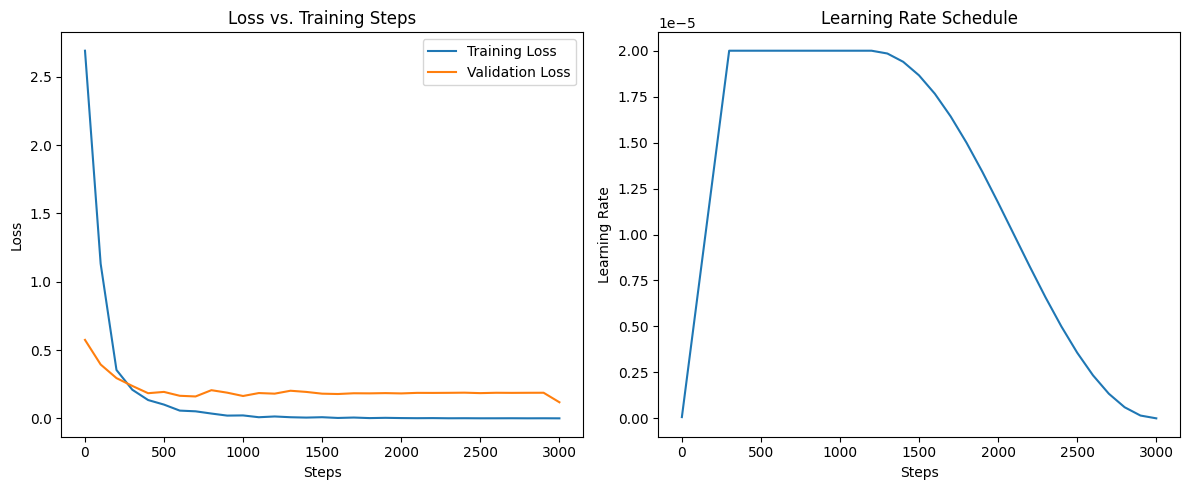

In [16]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
eval_loss = []
learning_rates = []
steps = []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "learning_rate" in entry:
        learning_rates.append(entry["learning_rate"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
if eval_loss:
    # eval_loss is per epoch — fewer points
    plt.plot(
        steps[:len(eval_loss)],  # align epochs to steps if possible
        eval_loss,
        label="Validation Loss"
    )
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Training Steps")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps[:len(learning_rates)], learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()

In [17]:
import pandas as pd

def tag_sentence(text:str):

    # convert our text to a  tokenized sequence
    inputs = tokenizer(text, truncation=True, return_tensors="pt", return_token_type_ids=False).to("cuda:0")

    # get outputs
    outputs = model(**inputs)

    # convert to probabilities with softmax
    probs = outputs[0][0].softmax(1)

    # get the tags with the highest probability
    word_tags = [(tokenizer.decode(inputs['input_ids'][0][i].item()), id2label[tagid.item()]) 
                  for i, tagid in enumerate (probs.argmax(axis=1))]

    return pd.DataFrame(word_tags, columns=['word', 'tag'])

In [18]:
sample = "O senador de São Paulo decidiu faltar a apelação, movida pelo Supremo Tribunal Federal."

tag_sentence(sample)

,word,tag
0,[CLS],O
1,O,O
2,sen,O
3,ador,O
4,de,O
5,São,O
6,Paulo,O
7,dec,O
8,idi,O
9,u,O
